# The first cell defines functions, just scroll down and see from the second cell

In [1]:
import qutip
import numpy as np
from matplotlib import pyplot as plt
import scqubits
from typing import List

def plot_specturum(qubit, resonator, hilbertspace, max_qubit_level = 4,max_resonator_level=3,
                    flagged_transitions = [[[0,0],[0,1]],[[1,0],[1,1]],[[2,0],[2,1]],[[3,0],[3,1]]]):
    energy_text_size = 8
    # clear_output(wait=True)
    qubit_ori_energies = qubit.eigenvals(max_qubit_level)
    resonator_ori_energies = resonator.eigenvals(max_resonator_level)
    fig, old_ax = qubit.plot_wavefunction(which = [0,1,2,3,4])
    left, bottom, width, height = 1, 0, 1, 1  
    ax = fig.add_axes([left, bottom, width, height])
    fig.set_size_inches(4, 4)
    for ql in range(0,max_qubit_level):
        for rl in range(0,max_resonator_level):
            original = (qubit_ori_energies[ql] + resonator_ori_energies[rl])* 2 * np.pi
            x1,x2 = ql-0.25,ql+0.25
            ax.plot([x1, x2], [original, original], linewidth=1, color='red')
            ax.text(ql, original, f"{original:.3f}", fontsize=energy_text_size, ha='center', va='bottom')

            dressed_state_index = hilbertspace.dressed_index((ql,rl))
            if dressed_state_index != None:
                dressed = hilbertspace.energy_by_dressed_index(dressed_state_index)* 2 * np.pi
                ax.plot([x1, x2], [dressed, dressed], linewidth=1, color='green')
                ax.text(ql, dressed, f"{dressed:.3f}", fontsize=energy_text_size, ha='center', va='top')
            else:
                print("dressed_state_index contain None")

    for transition in flagged_transitions:
        state1, state2 = transition[0],transition[1]
        dressed_index1 = hilbertspace.dressed_index((state1[0],state1[1]))
        dressed_index2 = hilbertspace.dressed_index((state2[0],state2[1]))
        if dressed_index1!= None and dressed_index2!= None:
            energy1 = hilbertspace.energy_by_dressed_index(dressed_index1)* 2 * np.pi
            energy2 = hilbertspace.energy_by_dressed_index(dressed_index2)* 2 * np.pi
            ax.plot([state1[0], state2[0]], [energy1, energy2], linewidth=1, color='green')
            ax.text((state1[0]+ state2[0])/2, (energy1+ energy2)/2, f"{energy2-energy1:.3f}", fontsize=energy_text_size, ha='center', va='top')
        else:
            print("dressed_state_index contain None")
    plt.show()


def resonator_frequency_over_2pi(osc):
    e_vals = osc.eigenvals()
    return (e_vals[1]-e_vals[0])

def undressed_transition_frequency_over_2pi(qubit, s0: int, s1: int):
    e_vals = qubit.eigenvals()
    return abs(e_vals[s0] - e_vals[s1])


def test_dispersive(res,qubit,sys):
    g_strength = hilbertspace.interaction_list[0].g_strength
    w_res = resonator_frequency_over_2pi(res)
    n_operator_matrix_element = fluxonium.matrixelement_table('n_operator')
    for states in [(0,1),(1,2)]:
        w_q = undressed_transition_frequency_over_2pi(qubit,states[0],states[1])
        print(f'for qubit transition {states}, detunning is {abs(w_res-w_q)}')
        rhs = g_strength*abs(n_operator_matrix_element[states[0],states[1]])  * np.sqrt(1) # osc.annihilation_operator().conj().T*osc.annihilation_operator() is a matrix full of zeros.
        print(f'rhs is {rhs}')


def sweep_osc_for_frequency():
    E_vals = np.linspace(1, 8, 80)
    l_vals = np.linspace(0, 3, 30)

    res = []
    for e in E_vals:
        res.append([])
        for l in l_vals:
            osc = scqubits.Oscillator(
                E_osc=e,
                l_osc = l,
                truncated_dim=3
            )
            res[-1].append(resonator_frequency_over_2pi(osc))
    res = np.array(res)
    plt.imshow(res, cmap='hot')
    plt.yticks(np.arange(len(E_vals)),E_vals)
    plt.xticks(np.arange(len(l_vals)),l_vals)
    plt.colorbar()
    plt.show()

def dressed_transition_frequency_over_2pi(hilbertspace,s0: List[int], s1: List[int]) -> float:
    s0 = hilbertspace.dressed_index(s0)
    s1 = hilbertspace.dressed_index(s1)
    return abs(hilbertspace.energy_by_dressed_index(s1) - hilbertspace.energy_by_dressed_index(s0))

def replace_non_float64_with_none(lst):
    for i in range(len(lst)):
        if type(lst[i]) is not np.float64:
            lst[i] = None
    return lst


def sweep_external_flux_for_detunning(EJ=7,
                                        EC=2.5,
                                        EL=0.5,omega_res=5):
    # for erasure detection, we want g0g1 detunned from e0e1 and f0f1
    # for measurement, we want one e0e1 detuned from the rest two.
    flux_vals = np.linspace(-0.5, 0.5, 100)
    g0g1_vals = []
    e0e1_vals = []
    f0f1_vals = []
    dispersive_limit01 = []
    dispersive_limit12 = []
    dispersive_limit23 = []
    for flux in flux_vals:
        qbt = scqubits.Fluxonium(
            EJ=EJ,
            EC=EC,
            EL=EL,
            flux=flux,
            cutoff=30,
            truncated_dim=5
        )
        osc = scqubits.Oscillator(
            E_osc=omega_res,
            truncated_dim=3
        )
        hilbertspace = scqubits.HilbertSpace([qbt, osc])
        g_strength = 0.2
        hilbertspace.add_interaction(
            g_strength=g_strength,
            op1=qbt.n_operator,
            op2=osc.creation_operator,
            add_hc=True
        )
        hilbertspace.generate_lookup()
        g0g1 = dressed_transition_frequency_over_2pi(hilbertspace,(0,0),(0,1))
        e0e1 = dressed_transition_frequency_over_2pi(hilbertspace,(1,0),(1,1))
        f0f1 = dressed_transition_frequency_over_2pi(hilbertspace,(2,0),(2,1))

        g0g1_vals.append(g0g1)
        e0e1_vals.append(e0e1)
        f0f1_vals.append(f0f1)
        g0g1_vals = replace_non_float64_with_none(g0g1_vals)
        e0e1_vals = replace_non_float64_with_none(e0e1_vals)
        f0f1_vals = replace_non_float64_with_none(f0f1_vals)
        n_operator_matrix_element = qbt.matrixelement_table('n_operator')
        dispersive_limit01.append(g_strength*abs(n_operator_matrix_element[0,1]))
        dispersive_limit12.append(g_strength*abs(n_operator_matrix_element[1,2]))
        dispersive_limit23.append(g_strength*abs(n_operator_matrix_element[2,3]))
    chi_ge_MHz = []
    for a, b in zip(e0e1_vals, g0g1_vals):
        if a is None or b is None:
            chi_ge_MHz.append(None)
        else:
            chi_ge_MHz.append((a - b)*1000)
    chi_gf_MHz = []
    for a, b in zip(f0f1_vals, g0g1_vals):
        if a is None or b is None:
            chi_gf_MHz.append(None)
        else:
            chi_gf_MHz.append((a - b)*1000)
    chi_ef_MHz = []
    for a, b in zip(f0f1_vals, e0e1_vals):
        if a is None or b is None:
            chi_ef_MHz.append(None)
        else:
            chi_ef_MHz.append((a - b)*1000)
    plt.plot(flux_vals, chi_ge_MHz, label=r'$\chi_{\mathrm{ge}}$')
    plt.plot(flux_vals, chi_gf_MHz, label=r'$\chi_{\mathrm{gf}}$')
    plt.plot(flux_vals, chi_ef_MHz, label=r'$\chi_{\mathrm{ef}}$')


    # plt.plot(flux_vals, dispersive_limit01, label='01')
    # plt.plot(flux_vals, dispersive_limit12, label='12')
    # plt.plot(flux_vals, dispersive_limit23, label='23')
    plt.legend()
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    plt.xlabel("flux bias on fluxonium")
    plt.ylabel("detunning (MHz) relevant for erasure and computational measurement")
    plt.show()




def sweep_resonator_frequency_for_detunning(EJ=6,
                                        EC=1,
                                        EL=1,
                                        flux = 0):
    # for erasure detection, we want g0g1 detunned from e0e1 and f0f1
    # for measurement, we want one e0e1 detuned from the rest two.
    E_vals = np.linspace(1, 10, 100)
    g0g1_vals = []
    e0e1_vals = []
    f0f1_vals = []
    dispersive_limit01 = []
    dispersive_limit12 = []
    dispersive_limit23 = []
    qbt = scqubits.Fluxonium(
            EJ=EJ,
            EC=EC,
            EL=EL,
            flux=flux,
            cutoff=30,
            truncated_dim=5
        )

    for e in E_vals:
        osc = scqubits.Oscillator(
            E_osc=e,
            truncated_dim=3
        )
        hilbertspace = scqubits.HilbertSpace([qbt, osc])
        g_strength = 0.2
        hilbertspace.add_interaction(
            g_strength=g_strength,
            op1=qbt.n_operator,
            op2=osc.creation_operator,
            add_hc=True
        )
        hilbertspace.generate_lookup()
        g0g1 = dressed_transition_frequency_over_2pi(hilbertspace,(0,0),(0,1))
        e0e1 = dressed_transition_frequency_over_2pi(hilbertspace,(1,0),(1,1))
        f0f1 = dressed_transition_frequency_over_2pi(hilbertspace,(2,0),(2,1))

        g0g1_vals.append(g0g1)
        e0e1_vals.append(e0e1)
        f0f1_vals.append(f0f1)
        g0g1_vals = replace_non_float64_with_none(g0g1_vals)
        e0e1_vals = replace_non_float64_with_none(e0e1_vals)
        f0f1_vals = replace_non_float64_with_none(f0f1_vals)
        n_operator_matrix_element = qbt.matrixelement_table('n_operator')
        # dispersive_limit01.append(g_strength*abs(n_operator_matrix_element[0,1]))
        # dispersive_limit12.append(g_strength*abs(n_operator_matrix_element[1,2]))
        # dispersive_limit23.append(g_strength*abs(n_operator_matrix_element[2,3]))
    chi_ge_MHz = []
    for a, b in zip(e0e1_vals, g0g1_vals):
        if a is None or b is None:
            chi_ge_MHz.append(None)
        else:
            chi_ge_MHz.append((a - b)*1000)
    chi_gf_MHz = []
    for a, b in zip(f0f1_vals, g0g1_vals):
        if a is None or b is None:
            chi_gf_MHz.append(None)
        else:
            chi_gf_MHz.append((a - b)*1000)
    chi_ef_MHz = []
    for a, b in zip(f0f1_vals, e0e1_vals):
        if a is None or b is None:
            chi_ef_MHz.append(None)
        else:
            chi_ef_MHz.append((a - b)*1000)
    plt.plot(E_vals, chi_ge_MHz, label=r'$\chi_{\mathrm{ge}}$')
    plt.plot(E_vals, chi_gf_MHz, label=r'$\chi_{\mathrm{gf}}$')
    plt.plot(E_vals, chi_ef_MHz, label=r'$\chi_{\mathrm{ef}}$')

    # plt.plot(E_vals, dispersive_limit01, label='01')
    # plt.plot(E_vals, dispersive_limit12, label='12')
    # plt.plot(E_vals, dispersive_limit23, label='23')
    plt.legend()
    plt.ylim([-100,100])
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    plt.xlabel("resonator frequency (GHz)")
    plt.ylabel("detunning (MHz)  relevant for erasure and computational measurement")
    plt.show()


def plot_fluxonium_matrix_elements(EJ=6,
                                    EC=1.3,
                                    EL=1,
                                    flux = 0):
    max_qubit_level = 8
    fluxonium = scqubits.Fluxonium(
                EJ=EJ,
                EC=EC,
                EL=EL,
                flux=flux,
                cutoff=30,
                truncated_dim=max_qubit_level
            )
    e_vals = fluxonium.eigenvals(max_qubit_level)
    tables = [fluxonium.matrixelement_table('n_operator'),fluxonium.matrixelement_table('phi_operator')]
    fig, axes = plt.subplots(1,2)
    fig.subplots_adjust(wspace=0.4)
    for ax,table in zip(axes,tables):
        n_levels = table.shape[0]
        for i in range(n_levels-1):
            for j in range(i, n_levels):
                if i in [0,1,2] and j in [0,1,2]:
                    color = 'black'
                else:
                    color = 'grey'
                frequency = abs(e_vals[i]-e_vals[j])
                element = abs(table[i,j])
                ax.plot([0, element], [frequency, frequency], linewidth=1, color=color)
                ax.text(element+0.1, frequency, str(i)+'-'+str(j), fontsize=10, ha='center', va='center')
    axes[0].set_title('n operator matrix elements')
    axes[1].set_title('phi operator matrix elements')

def get_coherence_effective(qbt,i,j):
    print('available noise channels: ')
    print(qbt.effective_noise_channels())
    t1_list = []
    t1_list.append(qbt.t1_capacitive(i=i,j=j))
    print(f'\nt1_capacitive:{t1_list[-1]}') 
    t1_list.append(qbt.t1_flux_bias_line(i=i,j=j))
    print(f't1_flux_bias_line:{t1_list[-1]} ') 
    t1_list.append(qbt.t1_inductive(i=i,j=j))
    print(f't1_inductive:{t1_list[-1]} ') 
    t1_list.append(qbt.t1_quasiparticle_tunneling(i=i,j=j))
    print(f't1_quasiparticle_tunneling:{t1_list[-1]} \n') 


    tphi_list = []
    tphi_list.append(qbt.tphi_1_over_f_cc(i=i,j=j))
    print(f'tphi_1_over_f_cc:{tphi_list[-1]}') 
    tphi_list.append(qbt.tphi_1_over_f_flux(i=i,j=j))
    print(f'tphi_1_over_f_flux:{tphi_list[-1]}\n') 

    one_over_t1_eff = 0
    for t1 in t1_list:
        one_over_t1_eff += 1/2*1/t1
    print(f'effective t1: {1/one_over_t1_eff}\n')

    one_over_t2_eff = one_over_t1_eff
    for tphi in tphi_list:
        one_over_t2_eff += 1/tphi
    print(f'effective t2: {1/one_over_t2_eff}\n') 

# The original fluxonium had |e> and |f> states producing similar dispersive shift on resonator frequency, so measuring the computational subspace is difficult.

# We want |g> separated from |e> and |f>, in addition, |e> and |f> should also be separated. (although we can do three state measurement for computational measurement, because if only |e> goes to |g>, it's also okay for QEC measurement)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

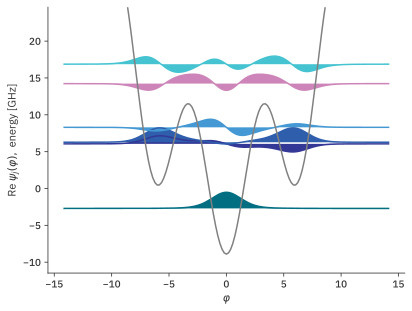

In [127]:
original_fluxonium = scqubits.Fluxonium(
            EJ=8.9,
            EC=2.5,
            EL=0.5,
            flux = 0,
            cutoff=110,
            truncated_dim=10
        )
original_fluxonium.plot_wavefunction(which = [0,1,2,3,4,5])

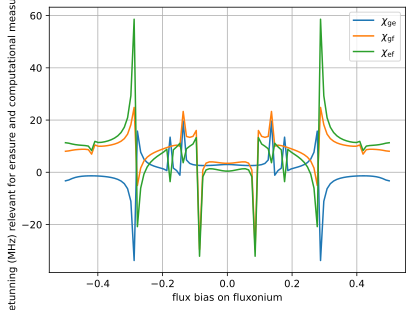

In [158]:
# The yellow and blue line are too close. The qubit-state-dependent shift on the resonator is too similar for e and f states.
# Or we can say the green line is too close to 0 at zero external flux bias
sweep_external_flux_for_detunning(EJ=8.9,
                                EC=2.5,
                                EL=0.5,omega_res = 6.5)

# EJ = 6, EC = 1.3, EL = 1 at zero external flux bias is kind of good

# The shift brought by g is separated from the shifts brought by e and f, and the shifts brought by e and f are separated.

## (note that this separation depends on the resonator being 8.5 GHz)

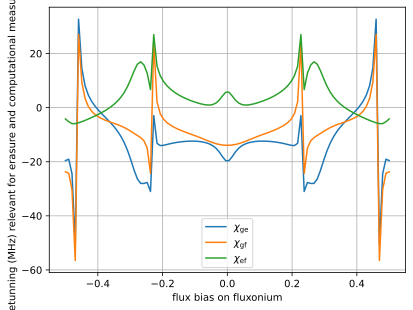

In [159]:
sweep_external_flux_for_detunning(EJ=6,
                                EC=1.3,
                                EL=1,omega_res = 8.5)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

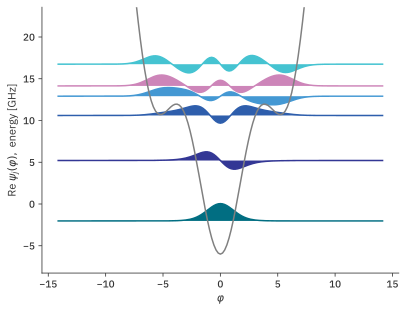

In [137]:
scqubits.Fluxonium(
            EJ=6,
            EC=1.3,
            EL=1,
            flux = 0,
            cutoff=110,
            truncated_dim=10
        ).plot_wavefunction(which = [0,1,2,3,4,5])

# The dispersive shifts sweeping across resonator frequency. Note that there's a plateau near 8.5Ghz.

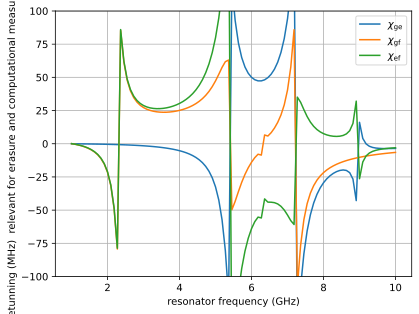

In [160]:
sweep_resonator_frequency_for_detunning(EJ=6,
                                EC=1.3,
                                EL=1,flux = 0)

# The matrix elements say |e> goes to |g> (small for |3>,|5>), this sounds like biased erasure. 
# |f> state couples to higher energy states, does it means easy leakage to higher states?

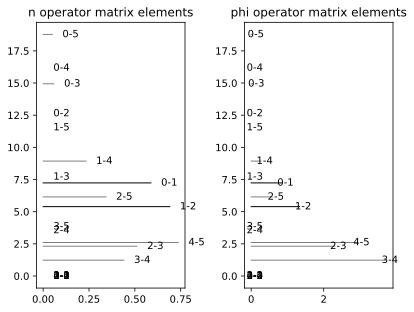

In [135]:
plot_fluxonium_matrix_elements(EJ=6,
                                    EC=1.3,
                                    EL=1,
                                    flux = 0)

# I'm not using good parameters in t1 compuation. I haven't looked into/learnt what those noise channels should be. But the EJ = 6, EC = 1.3, EL = 1 setup produces roughtly half the t1 and t2 of the roadmap paper qubit (https://arxiv.org/pdf/2201.09374.pdf)

In [121]:
erasure_fluxonium = scqubits.Fluxonium(
            EJ=6,
            EC=1.3,
            EL=1,
            flux = 0,
            cutoff=30,
            truncated_dim=5
        )

get_coherence_effective(erasure_fluxonium,1,2)

available noise channels: 
['tphi_1_over_f_cc', 'tphi_1_over_f_flux', 't1_capacitive', 't1_flux_bias_line', 't1_inductive', 't1_quasiparticle_tunneling']

t1_capacitive:17306.272780085055
t1_flux_bias_line:4912435.087147902 
t1_inductive:53536477.54250193 
t1_quasiparticle_tunneling:10378893.281066285 

tphi_1_over_f_cc:749679.0160675651
tphi_1_over_f_flux:5.952553869332982e+17

effective t1: 34422.75014922425

effective t2: 32911.56145039694



In [133]:
# This is the roadmap paper qubit
roadmap_fluxonium = scqubits.Fluxonium(
            EJ=4,
            EC=1,
            EL=1,
            flux = 1,
            cutoff=30,
            truncated_dim=5
        )


get_coherence_effective(roadmap_fluxonium,0,1)


available noise channels: 
['tphi_1_over_f_cc', 'tphi_1_over_f_flux', 't1_capacitive', 't1_flux_bias_line', 't1_inductive', 't1_quasiparticle_tunneling']

t1_capacitive:31675.336090322937
t1_flux_bias_line:5309552.411322315 
t1_inductive:129799432.86490141 
t1_quasiparticle_tunneling:26330739.9593606 

tphi_1_over_f_cc:625234.714045397
tphi_1_over_f_flux:3.3854755780309366e+18

effective t1: 62884.52563652361

effective t2: 57137.75482052494



In [134]:
# This is heavy fluxonium
heavy_fluxonium = scqubits.Fluxonium(
            EJ=3.395,
            EC=0.479,
            EL=0.132,
            flux = 0,
            cutoff=30,
            truncated_dim=5
        )

get_coherence_effective(heavy_fluxonium,0,1)


available noise channels: 
['tphi_1_over_f_cc', 'tphi_1_over_f_flux', 't1_capacitive', 't1_flux_bias_line', 't1_inductive', 't1_quasiparticle_tunneling']

t1_capacitive:20860339.72339931
t1_flux_bias_line:6449409154.934365 
t1_inductive:110248879846.21524 
t1_quasiparticle_tunneling:5466485201.287015 

tphi_1_over_f_cc:7102131.817604573
tphi_1_over_f_flux:1.0451915851574636e+16

effective t1: 41420804.77775333

effective t2: 6062617.722530346



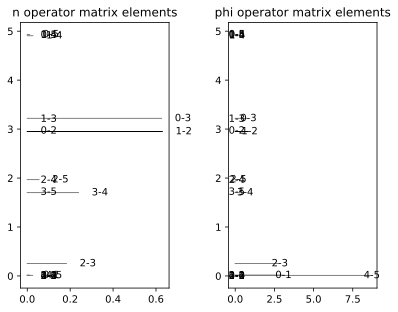

In [2]:
plot_fluxonium_matrix_elements(EJ=3.395,
                                    EC=0.479,
                                    EL=0.132,
                                    flux = 0.5)

# example Pauli noise model of leakage during idling and then perfect erasure conversion (used unpublish works from Michael Perlin)

In [2]:
import numpy as np
from qutip import *

Hef = Qobj(np.array([
    [0,0,0],
    [0, 0.70710678+0.j,  0.70710678+0.j],
    [0, 0.70710678+0.j, -0.70710678+0.j]]))

# Kraus representation of measuring g
Mg = Qobj(np.array([
    [1,0,0],
    [0,0,0],
    [0,0,0],
]))

# Kraus representation of measuring e or f
Mef = Qobj(np.array([
    [0,0,0],
    [0,1,0],
    [0,0,1],
]))

# Perfectly converting resetting the qubit in |e> state if we measured it in |g>
Xge = Qobj(np.array([
    [0,1,0],
    [1,0,0],
    [0,0,0],
]))

def truncate_rho_to_two_level(three_level_state):
    return Qobj(np.array([
        [three_level_state[1,1],three_level_state[1,2]],
        [three_level_state[2,1],three_level_state[2,2]]
    ]))

def truncate_ket_to_two_level(three_level_state):
    return Qobj(np.array([
        [three_level_state[1,0]],
        [three_level_state[2,0]]
    ]))

def L10():
    gamma = 5
    return np.sqrt(gamma)*basis(3,0)*basis(3,1).dag()

def decay_and_convert(three_level_state):
    liouvillian = lindblad_dissipator(L10())
    result = mesolve(H = qeye(3), 
                    rho0 = Qobj(three_level_state), 
                    tlist = np.linspace(0,0.1,200), 
                    c_ops = [liouvillian],
                    e_ops =[],
                    options=Options(store_final_state=True),
                    )
    decayed_state =  result.final_state
    erasure = Mg * decayed_state * Mg.dag()
    no_decay =  Mef * decayed_state * Mef.dag()
    converted_erasure = Xge * erasure * Xge
    mixed_state_rho =  converted_erasure+no_decay
    two_level_mixed_state_rho = truncate_rho_to_two_level(mixed_state_rho)
    two_level_converted_rho = truncate_rho_to_two_level(converted_erasure)
    two_level_no_leakage_rho = truncate_rho_to_two_level(no_decay)
    return two_level_mixed_state_rho, two_level_converted_rho.unit(), two_level_no_leakage_rho.unit()


def uPauli_for_noise_sampling(Pauli,U,U0,state1,state2):
    ################################################
    # This method is from an unpublished work of Michael Perlin of ColdQuanta
    # This describes the noise model we put into stim for noise sampling
    # The noise model for decoding would be different from this. 
    ################################################
    temp = state1*state2.dag()
    temp = U0.inv() * temp * U0.inv().dag()
    mixed, erasure, no_leakage = U(temp)

    temp1 = Pauli * mixed * Pauli.dag()
    temp2 = Pauli * erasure * Pauli.dag()
    temp3 = Pauli * no_leakage * Pauli.dag()
    temp1 = truncate_ket_to_two_level(state1).dag() * temp1  *truncate_ket_to_two_level(state2)
    temp2 = truncate_ket_to_two_level(state1).dag() * temp2  *truncate_ket_to_two_level(state2)
    temp3 = truncate_ket_to_two_level(state1).dag() * temp3  *truncate_ket_to_two_level(state2)

    return temp1[0,0],temp2[0,0],temp3[0,0]


d_mixed = {'X':[],'Y':[],"Z":[]}
d_erasure = {'X':[],'Y':[],"Z":[]}
d_no_leakage = {'X':[],'Y':[],"Z":[]}
for state1_name, state1 in zip(['e','f','+','-'],[basis(3,1),basis(3,2),Hef*basis(3,1),Hef*basis(3,2)]):
    for state2_name, state2 in zip(['e','f','+','-'],[basis(3,1),basis(3,2),Hef*basis(3,1),Hef*basis(3,2)]):
        for error_name,Pauli in zip(['X','Y','Z'],[sigmax(),sigmay(),sigmaz()]):
            uP_mixed,uP_erasure,uP_no_leakage = uPauli_for_noise_sampling(Pauli = Pauli,
                U = decay_and_convert,
                U0 = qeye(3),
                state1 = state1,
                state2 = state2)
            d_mixed[error_name].append(uP_mixed)
            d_erasure[error_name].append(uP_erasure)
            d_no_leakage[error_name].append(uP_no_leakage)

print('for mixed state/statistical average, the error model (we use for error sampling in stim) of e->g decay and erasure conversion is')
for key, val in d_mixed.items():
    print(key+' '+str(np.square(abs(np.mean(val)))))
print(r'for one shot, if we detect leakage and do erasure conversion (then normalize the $\rho$) , the error model (we use for decoding) is')
for key, val in d_erasure.items():
    print(key+' '+str(np.square(abs(np.mean(val)))))
print('for one shot, if we did not detect leakage, the error model (we use for decoding) is')
for key, val in d_no_leakage.items():
    print(key+' '+str(np.square(abs(np.mean(val)))))

/Users/jiakaiwang/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/sparse/_base.py:653: RuntimeWarning: divide by zero encountered in scalar divide
  r = self._mul_scalar(1./other)


for mixed state/statistical average, the error model (we use for error sampling in stim) of e->g decay and erasure conversion is
X 0.0
Y 0.0
Z 0.01223225214046328
for one shot, if we detect leakage and do erasure conversion (then normalize the $\rho$) , the error model (we use for decoding) is
X 0.0
Y 0.0
Z 0.13269751021448917
for one shot, if we did not detect leakage, the error model (we use for decoding) is
X 0.0
Y 0.0
Z 1.449296016583697e-05


# Let's see for one state how it evolves during erasure conversion

In [23]:
initial_state = Hef*basis(3,2) # X -1 state
ket2dm(initial_state)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.   0.   0. ]
 [ 0.   0.5 -0.5]
 [ 0.  -0.5  0.5]]

In [24]:
liouvillian = lindblad_dissipator(L10())
result = mesolve(H = qeye(3), 
                rho0 = Qobj(initial_state), 
                tlist = np.linspace(0,0.1,200), 
                c_ops = [liouvillian],
                e_ops =[],
                options=Options(store_final_state=True),
                )
decayed =  result.final_state
decayed

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.19673471  0.          0.        ]
 [ 0.          0.30326529 -0.38940039]
 [ 0.         -0.38940039  0.5       ]]

In [26]:
# For a signle shot,it would be (before  normalization)
converted_erasure

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         0.         0.        ]
 [0.         0.19673471 0.        ]
 [0.         0.         0.        ]]

In [27]:
# or 
measured_no_decay

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.        ]
 [ 0.          0.30326529 -0.38940039]
 [ 0.         -0.38940039  0.5       ]]